In [41]:
import pandas as pd
import numpy as np
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen
import statsmodels.formula.api as smf

import pandas as pd
import numpy as np
from StringIO import StringIO
from zipfile import ZipFile
from urllib import urlopen
import requests
import csv
import matplotlib.pylab as plt
import seaborn as sns
import pylab as pylab
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [84]:
def unzip_read_file(year):
    url = urlopen("http://www.nyc.gov/html/nypd/downloads/zip/analysis_and_planning/{}_sqf_csv.zip".format(year))
    zipfile = ZipFile(StringIO(url.read()))
    try:
        with zipfile.open("{}.csv".format(year)) as file:
            df = pd.read_csv(file)
            
    except: # 2015 csv name is different format than all the rest...go figure.
        with zipfile.open("{}_sqf_csv.csv".format(year)) as file:
            df = pd.read_csv(file)
    return df

In [106]:
df = pd.DataFrame()


In [107]:
# This will capture all data. Loading may take a while and will consume a fair amount of memory. 
# Recommended 16GB of memory if you want to run this cell...

# the rename is there to normalize the data from year to year. without,
# data of different years will not overlap properly

cols = []
#
for year in range(2003, 2016):
    year_df = unzip_read_file(year)
    year_df.rename(columns={'adrnum': 'addrnum', 'adrpct': 'addrpct', 'detailcm': 'detailCM', 
                            'dettyp_c': 'dettypCM', 'dettypcm': 'dettypCM', 'linecm': 'lineCM', 
                            'premtyp': 'premtype', 'prenam': 'prename', 'rescod': 'rescode',
                            'stinter': 'strintr', 'stname': 'strname'}, inplace=True)
    cols.append(list(year_df.columns))
    if len(list(year_df.columns)) != len(set(list(year_df.columns))):
        print sorted(list(year_df.columns))
    print year
    df = df.append(year_df)

2003
2004
2005
2006
2007
2008

/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (4,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (73) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



2009
2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (73,74,102,109,110) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (73,103) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



2011
2012

/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (10,73,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (10,73,83) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):



2013
2014
2015


/opt/rh/anaconda/root/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (10,83) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [108]:
# early years missing detailCM, so excluded at this point...

# 'year', 'pct', 'datestop', 'timestop', 'age' , 'perobs'


sqf_primary_select = df.loc[:,['inout', 'explnstp', 'arstmade', 
      'sumissue', 'frisked', 'searched', 'contrabn',  
      'rf_vcrim', 'rf_othsw', 'rf_attir', 'cs_objcs', 'cs_descr', 
      'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 
      'cs_furtv', 'rf_rfcmp', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 
      'cs_other',  'rf_knowl',  'sb_hdobj', 'sb_outln', 'sb_admis', 
      'sb_other', 'rf_furt', 'rf_bulg',  'sex', 'race']] # 'detailCM'

In [109]:
sqf_primary_select2 = df.loc[:,['year', 'inout', 'explnstp', 'arstmade', 
      'sumissue', 'frisked', 'searched', 'contrabn',  
      'rf_vcrim', 'rf_othsw', 'rf_attir', 'cs_objcs', 'cs_descr', 
      'cs_casng', 'cs_lkout', 'rf_vcact', 'cs_cloth', 'cs_drgtr', 
      'cs_furtv', 'rf_rfcmp', 'rf_verbl', 'cs_vcrim', 'cs_bulge', 
      'cs_other',  'rf_knowl',  'sb_hdobj', 'sb_outln', 'sb_admis', 
      'sb_other', 'rf_furt', 'rf_bulg',  'sex', 'race']]

In [110]:
def fix_nans(column):
    if column in [' ', '  ', '']:
        column = np.nan
    
    return column

In [111]:
for i in sqf_primary_select.columns:
    sqf_primary_select[i] = sqf_primary_select[i].apply(fix_nans)
    sqf_primary_select2[i] = sqf_primary_select2[i].apply(fix_nans)

In [112]:
# original data size
len(sqf_primary_select)

5052743

In [113]:
# Dataframe after nan reduction
sqf_primary_select.dropna(inplace=True)
sqf_primary_select2.dropna(inplace=True)

len(sqf_primary_select)

5008717

In [114]:
df.groupby('year').count()

,ac_assoc,ac_cgdir,ac_evasv,ac_incid,ac_inves,ac_other,ac_proxm,ac_rept,ac_stsnd,ac_time,...,sumissue,sumoffen,timestop,trhsloc,typeofid,weight,wepfound,xcoord,ycoord,zip
year,,,,,,,,,,,,,,,,,,,,,
2003,160851,160851,160851,160851,160851,160851,160851,160851,160851,160851,...,160851,160818,160851,160851,160851,160851,0,160851,160851,160851
2004,313523,313523,313523,313523,313523,313523,313523,313523,313523,313523,...,313523,313441,313523,313523,313523,313523,0,313523,313523,313523
2005,398191,398191,398191,398191,398191,398191,398191,398191,398191,398191,...,398191,398072,398191,398191,398191,398191,0,398191,398191,398191
2006,506491,506491,506491,506491,506491,506491,506491,506491,506491,506491,...,506491,506424,506491,506491,506491,506491,506491,506491,506491,506491
2007,472096,472096,472096,472096,472096,472096,472096,472096,472096,472096,...,472096,472032,472096,472096,472096,472096,0,472096,472096,472096
2008,540302,540302,540302,540302,540302,540302,540302,540302,540302,540302,...,540302,540263,540302,540302,540302,540302,0,540302,540302,540302
2009,581168,581168,581168,581168,581168,581168,581168,581168,581168,581168,...,581168,581138,581168,581168,581168,581168,0,581168,581168,581168
2010,601285,601285,601285,601285,601285,601285,601285,601285,601285,601285,...,601285,601231,601285,601285,601285,601285,0,601285,601285,601285
2011,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724,...,685724,685705,685724,685724,685724,685724,0,685724,685724,685724


In [115]:
sqf_primary_select2.groupby('year').count()

,inout,explnstp,arstmade,sumissue,frisked,searched,contrabn,rf_vcrim,rf_othsw,rf_attir,...,cs_other,rf_knowl,sb_hdobj,sb_outln,sb_admis,sb_other,rf_furt,rf_bulg,sex,race
year,,,,,,,,,,,,,,,,,,,,,
2003,159887,159887,159887,159887,159887,159887,159887,159887,159887,159887,...,159887,159887,159887,159887,159887,159887,159887,159887,159887,159887
2004,300813,300813,300813,300813,300813,300813,300813,300813,300813,300813,...,300813,300813,300813,300813,300813,300813,300813,300813,300813,300813
2005,383920,383920,383920,383920,383920,383920,383920,383920,383920,383920,...,383920,383920,383920,383920,383920,383920,383920,383920,383920,383920
2006,506486,506486,506486,506486,506486,506486,506486,506486,506486,506486,...,506486,506486,506486,506486,506486,506486,506486,506486,506486,506486
2007,467007,467007,467007,467007,467007,467007,467007,467007,467007,467007,...,467007,467007,467007,467007,467007,467007,467007,467007,467007,467007
2008,540175,540175,540175,540175,540175,540175,540175,540175,540175,540175,...,540175,540175,540175,540175,540175,540175,540175,540175,540175,540175
2009,581168,581168,581168,581168,581168,581168,581168,581168,581168,581168,...,581168,581168,581168,581168,581168,581168,581168,581168,581168,581168
2010,601285,601285,601285,601285,601285,601285,601285,601285,601285,601285,...,601285,601285,601285,601285,601285,601285,601285,601285,601285,601285
2011,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724,...,685724,685724,685724,685724,685724,685724,685724,685724,685724,685724


In [116]:
# Data cleaning to generate numeric values


d = {'Y': True, 'N': False}
sqf_primary_select = sqf_primary_select.replace(d)

In [117]:
sqf_primary_numeric = pd.get_dummies(sqf_primary_select)

In [118]:
len(sqf_primary_numeric.columns)

43

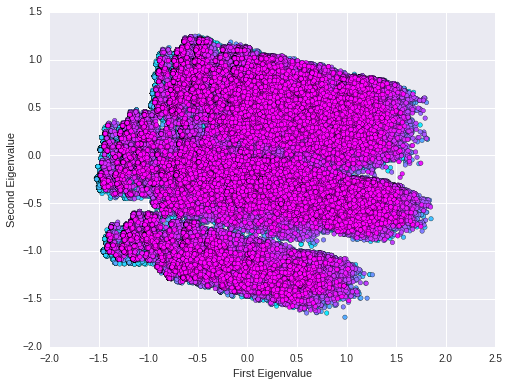

In [119]:
n=3 # how many eigenvectors we choose
pca = PCA(n)
Proj = pca.fit_transform(sqf_primary_numeric)
eigenvalues = pca.explained_variance_
plt.figure(figsize=(8, 6))
# Plot the training points
plt.scatter(Proj[:, 0], Proj[:, 1], c=sqf_primary_select2.year, cmap=plt.cm.cool)
plt.xlabel('First Eigenvalue')
plt.ylabel('Second Eigenvalue')
plt.show()

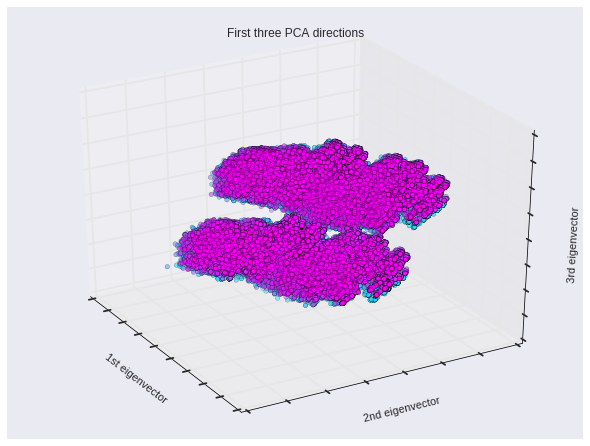

In [120]:

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=30)
ax.scatter(Proj[:, 0], Proj[:, 1], Proj[:, 2],c=sqf_primary_select2.year,
           cmap=plt.cm.cool)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()